In [2]:
# This code fits a Fourier spectrum to the SGS topography corresponding
# to a given lat,lon. The workflow is as follows: find the low-res ICON triangle
# whose centroid is closest to the given reference location, fetch the data within 
# this triangle, fit the linear-regression-based Fourier spectrum to it, and finally 
# plot the spectrum and the reconstructed topography along with the reference truth.
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy.ma as ma
from topoPy import *

In [3]:
# ICON grid file
df = nc.Dataset('icon_grid_0012_R02B04_G.nc')
# print(df.variables)

# store the lat,lon of the vertices and the centre of each triangular grid
clat = ma.getdata(df.variables['clat'][:])
clat_vertices = ma.getdata(df.variables['clat_vertices'][:])
clon = ma.getdata(df.variables['clon'][:])
clon_vertices = ma.getdata(df.variables['clon_vertices'][:])

# change to degrees
clat, clat_vertices = clat*(180/np.pi), clat_vertices*(180/np.pi)
clon, clon_vertices = clon*(180/np.pi), clon_vertices*(180/np.pi)

In [4]:
# pick the cell around the reference lat,lon
def pickCell(lat_ref, lon_ref, clat, clon):
    index = np.nonzero((np.abs(clat-lat_ref)<=1) & 
                       (np.abs(clon-lon_ref)<=1))[0]
    
    print("index = ", index)
    # pick the centre closest to the reference location
    dist = np.abs(clat[index]-lat_ref) + np.abs(clon[index]-lon_ref) 
    print("dist = ", dist)
    ind = np.argmin(dist)
    print("ind = ", ind)
    return index[ind]

In [5]:
# N_coor = -31.8894588
# E_coor = -70.6014078

N_coor = 45
E_coor = 45

print(np.argmin(clat - N_coor))
print(np.argmin(clon - E_coor))

17408
11272


In [6]:
#---- pick the ICON cell for a given reference location
# lat_ref = 43
# lon_ref = 42

# lat_ref = -32
# lon_ref = -71
lat_ref, lon_ref = 28, 87 # Langtang National Park, Nepal
# lat_ref, lon_ref = 42,23 # Pirin National Park, Bulgaria
lat_ref, lon_ref = 50,8 # Taunus
lat_ref, lon_ref = 46,8 # Firehorn, Switzerland
vid = pickCell(lat_ref,lon_ref,clat,clon) # pick a vertex
print('Vertex ID:',vid)

#---- get the data for the picked cell
datfile = 'GMTED2010_topoGlobal_SGS_30ArcSec.nc'
var = {'name':'topo','units':'m'}
#---- set (lon,lat) of the centre of the grid
lon_centre = clon[vid]    # in degrees
lat_centre = clat[vid]    # in degrees
#---- set the periphery of the coarse grid around the centre 
lon_width = 4  # in degrees
lat_width = 4  # in degrees
#---- get the topography around the cell picked
%time lon,lat,z = fetch_data(datfile,var,lon_centre,lat_centre,lon_width,lat_width)

index =  [4631]
dist =  [0.72636156]
ind =  0
Vertex ID: 4631
{'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(nfiles, lat)
    units: degrees
unlimited dimensions: 
current shape = (108, 2400)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(nfiles, lon)
    units: degrees
unlimited dimensions: 
current shape = (108, 3600)
filling on, default _FillValue of 9.969209968386869e+36 used, 'topo': <class 'netCDF4._netCDF4.Variable'>
float32 topo(nfiles, lat, lon)
    units: meters
unlimited dimensions: 
current shape = (108, 2400, 3600)
filling on, default _FillValue of 9.969209968386869e+36 used}
n =  0
[]
n =  1
[]
n =  2
[]
n =  3
[]
n =  4
[]
n =  5
[]
n =  6
[]
n =  7
[]
n =  8
[]
n =  9
[]
n =  10
[]
n =  11
[]
n =  12
[]
n =  13
[]
n =  14
[]
n =  15
[]
n =  16
[]
n =  17
[]
n =  18
[]
n =  19
[]
n =  20
[]
n =  21
[]
n =  22
[]
n =  23
[]
n =  24
[6307905 6307906 6307907 ... 8032782 8032783 8032784]
n =  25
[

In [30]:
print(vid)
print(lon_centre, lat_centre)
# print(lat)
# print(lon)
# print(z.min(), z.max())
# print(z[-1])

19442
-70.60252533260288 -31.955413552374605


In [31]:
print(lat.shape, lon.shape, z.shape)

(480,) (480,) (480, 480)


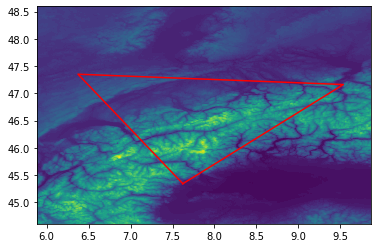

In [7]:
# plot the topo and the ICON triangle
plt.contourf(lon,lat,z,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.show()

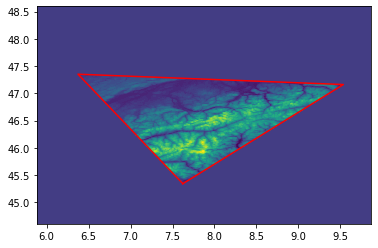

In [8]:
# Plot the topo within the ICON triangle
vi = clat_vertices[vid,:]
vj = clon_vertices[vid,:]
inout = [pointInTriangle(vi,vj,i,j) for i in lat for j in lon]
inout = np.array(inout).reshape(len(lat),len(lon))
z_masked = z*inout

plt.contourf(lon,lat,z_masked,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.show()

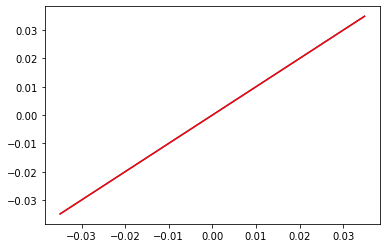

5.5228359047734795e-05


In [10]:
tmin = -2.0 / 180 * np.pi
tmax = -tmin
trange = np.linspace(tmin, tmax, 100)
plt.figure()
plt.plot(trange , np.tan(trange))
plt.plot(trange, trange ,'r')
# plt.xlabel(trange, trange / np.pi * 180)
plt.show()

print(np.linalg.norm(np.tan(trange) - trange))

In [11]:
A = 6371.0008
A = 1.0

print(lat.min(), lat.max())
print(lon.min(), lon.max())

def ll_xy_projection(lat, lon, lat_c, lon_c):
    lat = lat / 180.0 * np.pi
    lon = lon / 180.0 * np.pi
    lat_c = lat_c / 180.0 * np.pi
    lon_c = lon_c / 180.0 * np.pi
    dlat = lat - lat_c
    dlon = lon - lon_c
    print("max(dlat, dlon) = ", dlat.max(), dlon.max())
    
    xp = A * np.cos(lat) * dlon
    yp = A * dlat
    
    return yp, xp

# ll_xy_projection(lat, lon, lat_centre, lon_centre)
lat_proj, lon_proj = ll_xy_projection(lat, lon, lat_centre, lon_centre)

print(lat_proj.min(), lat_proj.max())
print(lon_proj.min(), lon_proj.max())

-33.954166412353516 -29.962499618530273
-72.59583282470703 -68.60416412353516
max(dlat, dlon) =  0.03478290985445609 0.03487798274236642
-0.03488481834028523 0.03478290985445609
-0.02885758681509277 0.03021662652648903


max(dlat, dlon) =  0.017278475741169474 0.014957870463379708
[ 0.01727848 -0.00179285 -0.01648007] [ 0.01156905 -0.02067122  0.01255897]


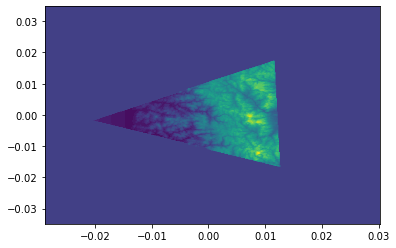

In [12]:
vi = clat_vertices[vid,:]
vj = clon_vertices[vid,:]

vip, vjp = ll_xy_projection(vi, vj, lat_centre, lon_centre)
print(vip, vjp)
inout = [pointInTriangle(vip,vjp,i,j) for i in lat_proj for j in lon_proj]
inout = np.array(inout).reshape(len(lat_proj),len(lon_proj))
z_masked_p = z*inout

plt.figure()
plt.contourf(lon_proj,lat_proj,z_masked_p,60)
x = np.append(vip,vip[0])
y = np.append(vjp,vjp[0])

# plt.plot(x,y,'-r')
plt.show()

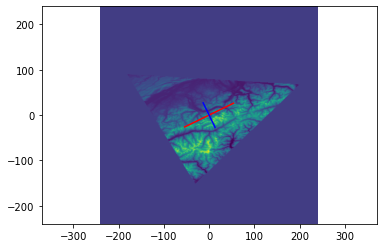

In [9]:
import imageio as misc

def raw_moment(data, i_order, j_order):
    nrows, ncols = data.shape
    y_indices, x_indicies = np.mgrid[:nrows, :ncols]
    return (data * x_indicies**i_order * y_indices**j_order).sum()


def moments_cov(data):
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_centroid = m10 / data_sum
    y_centroid = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_centroid * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_centroid * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_centroid * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])
    return cov

# img = misc.imread('oval.png')
img = np.copy(z_masked)
y, x = np.nonzero(img)

xm = np.mean(x)
ym = np.mean(y)

x = x - xm
y = y - ym
coords = np.vstack([x, y])

cov = moments_cov(img)
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]

scale = 30.0
plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
# plt.plot(x, y, 'k.')

# lon_shft = lon-lon.mean()
# lat_shft = lat-lat.mean()
# plt.contourf(lon_shft,lat_shft,z_masked,60)
plt.axis('equal')
# plt.gca().invert_yaxis()  # Match the image system with origin at top left
plt.show()

-0.45224259811737355


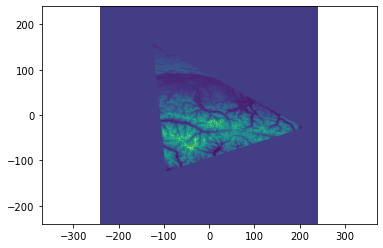

In [10]:
# coords = np.vstack([lon_shft, lat_shft])

# theta = (np.arctan((x_v2-x_v1)/(y_v2-y_v1)))
theta = -np.arctan((y_v1)/(x_v1)) 
# theta = -np.pi/2.0
print(theta)

rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
transformed_mat = rotation_mat * coords
# plot the transformed blob
x_transformed, y_transformed = transformed_mat.A

# print(x_transformed)
yarg, xarg = np.nonzero(img)

# x = x - np.mean(x)
# y = y - np.mean(y)

# plt.plot(x_transformed, y_transformed, 'g.')

x_transformed = np.round(x_transformed + xm)
y_transformed = np.round(y_transformed + ym)

# print(x_transformed.shape)
z_transformed = np.zeros_like(z_masked)
# z_transformed[x_transformed.astype(int),y_transformed.astype(int)] = z_masked[x.astype(int),y.astype(int)]
z_transformed[y_transformed.astype(int),x_transformed.astype(int)] = z_masked[yarg,xarg]

# plt.plot(x, y, 'r.')

# plt.imshow(z_masked)
# print(x_transformed.shape, y_transformed.shape)
# plt.contourf(x_transformed, y_transformed,z_,60)
plt.imshow(z_transformed, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
plt.axis('equal')
plt.show()

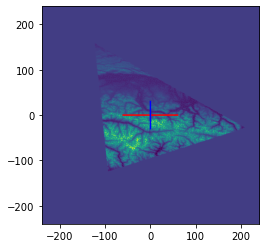

In [11]:
img = np.copy(z_transformed)
y, x = np.nonzero(img)

xm = np.mean(x)
ym = np.mean(y)

x = x - xm
y = y - ym
coords = np.vstack([x, y])

cov = moments_cov(img)
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]

scale = 30.0
plt.imshow(z_transformed, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.show()

In [12]:
theta = np.arctan((y_v1)/(x_v1)) 
# theta = -np.pi/2.0
print(theta)

-6.983002142844124e-05


In [12]:
print(lat[0], lon[0])
print(vi, vj)
print(inout.sum())

40.59583282470703 40.3125
[43.66441397 41.63361439 42.36500885] [41.44424379 41.24515306 43.96808206]
38764


In [13]:
# vectorize the selected topography and the corresponding lat,lon
lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)
lat_cell,lon_cell,z_cell = lat_mgrid[inout],lon_mgrid[inout],z[inout]

In [14]:
print(z_cell[999])

-1242.9002685546875


In [14]:
# now define appropriate indices for the points withing the triangle
# by shifting the origin to the minimum lat and lon
lat_res = lat[1] - lat[0]
lon_res = lon[1] - lon[0]
I = np.ceil((lat_cell - lat_cell.min())/lat_res).astype(int)
J = np.ceil((lon_cell - lon_cell.min())/lon_res).astype(int)

In [16]:
print(J[:200])

[ 0  1  1  2  3  4  5  1  2  3  4  5  6  7  8  9  1  2  3  4  5  6  7  8
  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16  1  2  3  4
  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  1  2  3  4  5  6  7  8  9
 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27  1  2  3  4  5  6
  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35  1  2  3  4  5  6  7  8  9 10 11 12
 13 14 15 16 17 18 19 20]


In [17]:
# def fitFourierSeries(data,Ni,Nj,I,J,nhar_i,nhar_j):
    # data, I, J must be in 1D
    # Ni, Nj: total number of points in i and j indices
    # nhar_i, nhar_j: number of harmonics in i and j index
    
    # number of harmonics for x,y
# m_i, n_j = range(nhar_i), range(nhar_j)

# # basis matrix
# basis_cos = []
# basis_sin = []
# for k in range(len(data)):
#     coeff_cos = [np.cos(2*np.pi*(mm*I[k]/Ni + nn*J[k]/Nj)) for mm in m_i for nn in n_j]
#     coeff_sin = [np.sin(2*np.pi*(mm*I[k]/Ni + nn*J[k]/Nj)) for mm in m_i for nn in n_j if mm!=0 or nn!=0]
#     basis_cos.append(coeff_cos)
#     basis_sin.append(coeff_sin)

# coeff = np.hstack([basis_cos,basis_sin])
# print(coeff.shape)
# tot_coeff = coeff.shape[1]
# print('Total coefficients:',tot_coeff)

# # Solve: data_k = \sum basis_kl*a_l + \epsilon
# # obtain a_l using least square minimization of the error \epsilon
# # alternative

# h_tilda_l = np.zeros((tot_coeff,))
# E_tilda_lm = np.zeros((tot_coeff,tot_coeff))

# for l in range(tot_coeff):
#     h_tilda_l[l] = np.sum(data*coeff[:,l])
#     E_tilda_lm[l,:] = np.sum(coeff*np.expand_dims(coeff[:,l], axis=1), axis=0)

# # now invert E_tilda_lm to get the coefficients
# a_m = np.linalg.inv(E_tilda_lm).dot(h_tilda_l)

# # regular FFT considers normalization by total number of datapoints N=100
# # so multiply the Fourier coefficients by N here
# a_m = a_m*len(data)

# mid = (a_m.size+1)//2
# fourier_coeff = (a_m[1:mid] + 1j*a_m[mid:])/2    # half the amplitudes are the Fourier coefficients
# fourier_coeff = np.insert(fourier_coeff,0,a_m[0])
# fourier_coeff = fourier_coeff.reshape((nhar_i,nhar_j))

# # reconstruct the dataset
# data_recons = coeff.dot(a_m)/len(data)
    
#     return fourier_coeff, data_recons

In [246]:
#---- fit the spectrum
# please note that the spectrum is sensitive to the total number of fitted
# harmonics. I did a sensitivity analysis and found that fittig 15 wavenumbers 
# works good in general
nhar_i = 16
nhar_j = 16
Ni, Nj = np.unique(lat_cell).size, np.unique(lon_cell).size


data,Ni,Nj,I,J,nhar_i,nhar_j = z_cell,Ni,Nj,I,J,nhar_i,nhar_j

#---- Approach 1
# print('Approach 1')
# spec = fitFourierSpec(z_cell,Ni,Nj,I,J,nhar_i,nhar_j)
# spec = spec.reshape((2*nhar_lat-1,2*nhar_lon-1))
# mid_i = nhar_lat-1; mid_j = nhar_lon-1 
# fourier_coeff1 = spec[mid_i:,mid_j:]

#---- Approach 2
print('Approach 2')

m_i, n_j = range(nhar_i), range(nhar_j)

# k = np.array([k for k in range(len(data))])

m_i = np.arange(0,nhar_i)
# m_j = np.arange(0,nhar_j)
m_j = np.arange(-nhar_j/2,nhar_j/2)

term1 = m_i.reshape(1,-1) * I.reshape(-1,1) / Ni
term2 = m_j.reshape(1,-1) * J.reshape(-1,1) / Nj

term1 = np.expand_dims(term1,-1)
term1 = np.repeat(term1,nhar_j,-1)
term2 = np.expand_dims(term2,1)
term2 = np.repeat(term2,nhar_i,1)
# term2 = np.transpose(term2,(0,2,1))

tt_sum = term1 + term2
tt_sum = tt_sum.reshape(tt_sum.shape[0],-1)
bcos = np.cos(2.0 * np.pi * (tt_sum))
bsin = np.sin(2.0 * np.pi * (tt_sum))
# bsin = np.sin(2.0 * np.pi * (tt_sum[:,1:]))

# i_chk = np.repeat(np.expand_dims(m_i,0),len(I),0)
# j_chk = np.repeat(np.expand_dims(m_j,0),len(J),0)

# i_chk = np.expand_dims(i_chk,-1)
# j_chk = np.expand_dims(j_chk,1)

# i_chk = np.repeat(i_chk,nhar_j,-1)
# j_chk = np.repeat(j_chk,nhar_i,1)

Ncos = bcos[:,8:]
Nsin = bsin[:,9:]

# print(bcos.shape)
# print(bsin.shape)

Approach 2


In [253]:
# print(i_chk)
# print(tt_sum.shape)

# Ncos = tt_sum[~((i_chk == 0) & (j_chk < 0.))]
# Ncos = np.cos( 2.0 * np.pi * Ncos.reshape(len(I),int((nhar_i * nhar_j - nhar_j/2))) )

# Nsin = tt_sum[~((i_chk == 0) & (j_chk <= 0.))]
# Nsin = np.sin( 2.0 * np.pi * Nsin.reshape(len(J),int((nhar_i * nhar_j - nhar_j/2 - 1))) )
# print(Ncos.shape)

In [68]:
# print(bcos[0,8:])
# print(bsin[0,9:])

In [113]:
# print(bcos[:,7:].shape)
# print(bsin[:,8:].shape)

(44091, 241)
(44091, 239)


In [24]:
# basis matrix
basis_cos = []
basis_sin = []

for k in range(len(data)):
    coeff_cos = [np.cos(2*np.pi*(mm*I[k]/Ni + nn*J[k]/Nj)) for mm in m_i for nn in n_j]
    coeff_sin = [np.sin(2*np.pi*(mm*I[k]/Ni + nn*J[k]/Nj)) for mm in m_i for nn in n_j if mm!=0 or nn!=0]
    basis_cos.append(coeff_cos)
    basis_sin.append(coeff_sin)

basis_cos = np.array(basis_cos)
basis_cos.shape

KeyboardInterrupt: 

In [247]:
# coeff = np.hstack([basis_cos,basis_sin])
coeff = np.hstack([Ncos,Nsin])
print(coeff.shape)
tot_coeff = coeff.shape[1]
print('Total coefficients:',tot_coeff)

# Solve: data_k = \sum basis_kl*a_l + \epsilon
# obtain a_l using least square minimization of the error \epsilon
# alternative

# h_tilda_l = np.zeros((tot_coeff,))
E_tilda_lm = np.zeros((tot_coeff,tot_coeff))

# for l in range(tot_coeff):
#     h_tilda_l[l] = np.sum(data*coeff[:,l])
#     E_tilda_lm[l,:] = np.sum(coeff*np.expand_dims(coeff[:,l], axis=1), axis=0)
    
h_tilda_l = (data.reshape(-1,1) * coeff).sum(axis=0)

for k in range(0,len(data)):
    E_tilda_lm += np.expand_dims(coeff[k],-1) * np.expand_dims(coeff[k],0)

(44091, 495)
Total coefficients: 495


In [248]:
# now invert E_tilda_lm to get the coefficients
import scipy.linalg as la

a_m = la.inv(E_tilda_lm).dot(h_tilda_l)

# regular FFT considers normalization by total nu  mber of datapoints N=100
# so multiply the Fourier coefficients by N here
a_m = a_m*len(data)

mid = (a_m.size+1)//2
fourier_coeff = (a_m[1:mid] + 1j*a_m[mid:])/2    # half the amplitudes are the Fourier coefficients
fourier_coeff = np.insert(fourier_coeff,0,a_m[0])
fourier_coeff = fourier_coeff#.reshape((nhar_i,nhar_j))

# reconstruct the dataset
data_recons = coeff.dot(a_m)/len(data)

fourier_coeff2, recons_z = fourier_coeff, data_recons
# fourier_coeff2, recons_z = fitFourierSeries(z_cell,Ni,Nj,I,J,nhar_i,nhar_j)

In [249]:
# reshape the reconstructed topography to the trianglular form
recons_z_2D = np.zeros(np.shape(z))
c = 0
for i in range(len(lat)):
    for j in range(len(lon)):
        if (inout[i,j] == 1):
            recons_z_2D[i,j] = recons_z[c]
            c = c+1

print(c)

44091


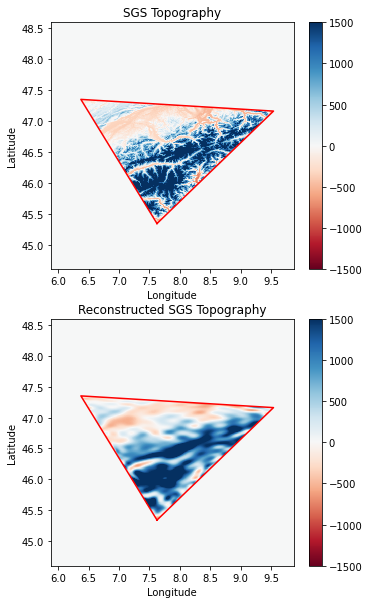

In [250]:
#---- plot the topography and the spectrum
fig = plt.figure(figsize=(12,10))
vmin=-1500; vmax=1500
# plot the topography within the cell
ax1 = fig.add_subplot(221)
# always use pcolormesh for plotting data with fine structures
sp1 = ax1.pcolormesh(lon_mgrid,lat_mgrid,z_masked,
                     vmin=vmin,vmax=vmax,cmap=mpl.cm.RdBu,shading='auto')
# draw the cell
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
ax1.plot(x,y,'-r')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('SGS Topography')
fig.colorbar(sp1,ax=ax1)

# plot the spectrum -- Approach 1
#ax2 = fig.add_subplot(222)
#sp2 = plt.contourf(np.abs(spec),60)
#sp2 = plt.contourf(fourier_coeff1.real,60)
#ax2.set_xlabel(r'$k_x$',fontsize=14)
#ax2.set_ylabel(r'$k_y$',fontsize=14)
#ax2.set_title('SGS Spectrum (Approach 1)')
#cmap = mpl.cm.viridis
#norm = mpl.colors.Normalize(vmin=-10,vmax=10)
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap))
#plt.colorbar()

# plot the spectrum -- Approach 2
# ax2 = fig.add_subplot(222)
# sp2 = ax2.contourf(np.abs(fourier_coeff2),60)
# fig.colorbar(sp2,ax=ax2)
# ax2.set_xlabel(r'$k_x$',fontsize=14)
# ax2.set_ylabel(r'$k_y$',fontsize=14)
# ax2.set_title('SGS power spectrum')

# plot the reconstructed data
ax3 = fig.add_subplot(223)
sp3 = ax3.pcolormesh(lon_mgrid,lat_mgrid,recons_z_2D,
                     cmap=mpl.cm.RdBu,vmin=vmin,vmax=vmax,shading='auto')
plt.plot(x,y,'-r')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Reconstructed SGS Topography')
fig.colorbar(sp3)
plt.show()
fig.savefig('SGS_spectrum_recons_andes.jpeg',dpi=300)

In [251]:
ZZ = np.load('z.npy')

(480, 480)
(480, 480)


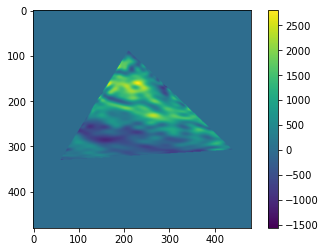

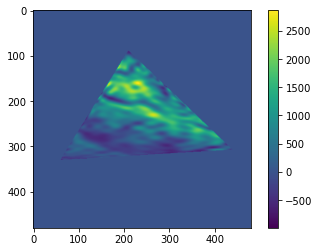

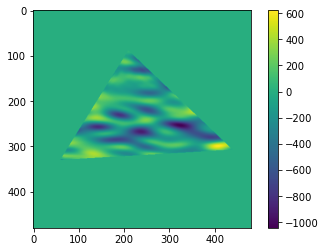

86398.24865043767
72377.44216692743


In [252]:
print(ZZ.shape)
print(recons_z_2D.shape)
plt.figure()
plt.imshow(ZZ)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(recons_z_2D)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(ZZ-recons_z_2D)
plt.colorbar()
plt.show()

print(la.norm(ZZ-z_masked)) #/ sum(z_masked))
print(la.norm(recons_z_2D-z_masked))# / sum(z_masked))